In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import os
os.chdir('../')

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tcav
from src.download_data import download_imagenet, download_random_imagenet_classes
import pickle
from src.dataset import *
from src.concept_vectors import *
from src.util import *
import random
from src.plots import *
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine 
import pandas as pd
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from src.hierarchy import *
from src.metrics import *

In [4]:
from PIL import Image

In [25]:
input_image = "dataset/colored_mnist/images/0/9994.png"
output_image = "dataset/colored_mnist_robustness/images/0/9994.png"

In [26]:
func = lambda img: add_gaussian_noise(img,0,50)

In [42]:
write_new_image_function(input_image,output_image,create_junk_image)

<IPython.core.display.Javascript object>


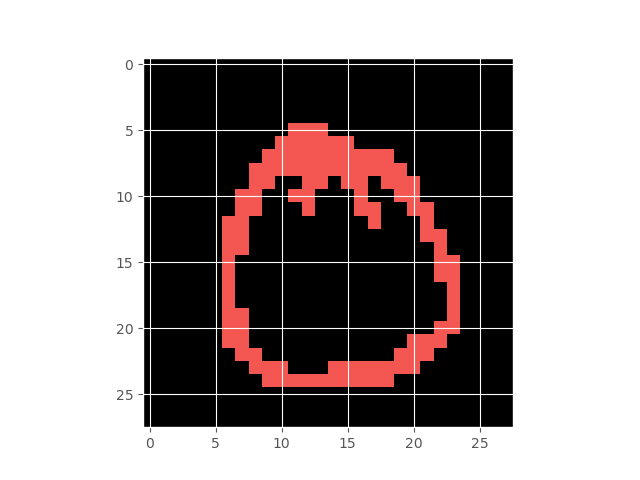

In [43]:
plt.figure()
plt.imshow(Image.open(input_image))

<IPython.core.display.Javascript object>


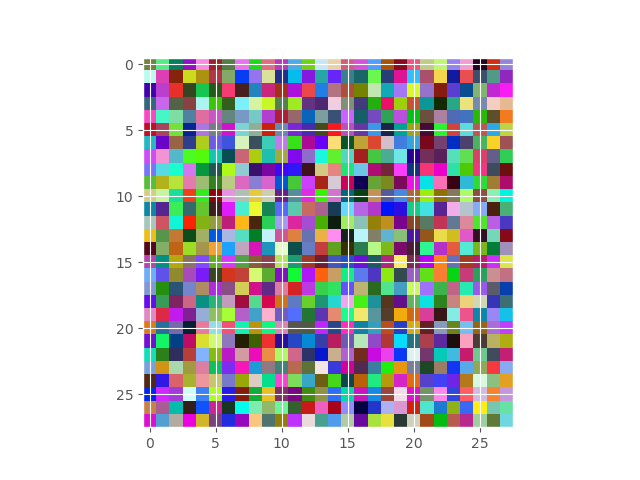

In [44]:
plt.figure()
plt.imshow(Image.open(output_image))

In [10]:
plt.
plt.show()

In [4]:
load_cem_vectors("xor",0,42).shape

(48, 16)

In [5]:
load_tcav_vectors("soccer",['mixed4c'],experiment_name="unfiled")[0].shape

(2, 100352)

In [6]:
load_label_vectors_simple("has_bill_shape::dagger","cub",seed=42).shape

(1, 4796)

In [7]:
load_cem_vectors_simple('0','xor',seed=42).shape

(48, 16)

In [5]:
mnist_attributes = ['{}_color'.format(i) for i in range(5)] + ['{}_number'.format(i) for i in range(5)]

In [6]:
stability_metric(create_linkage_hierarchy,load_tcav_vectors_simple,'mnist',mnist_attributes,[43,44,45])

14.0

In [7]:
stability_metric(create_ward_hierarchy,load_tcav_vectors_simple,'mnist',mnist_attributes,[43,44,45])

16.333333333333332

In [8]:
stability_metric(create_ward_hierarchy,load_cem_vectors_simple,'mnist',mnist_attributes,[43,44,45])

19.666666666666668

In [9]:
stability_metric(create_ward_hierarchy,load_label_vectors_simple,'mnist',mnist_attributes,[43,44,45])

0.0

In [18]:
np.load('./results/cem_concepts/mnist/43/mnist_concept_0_inactive.npy')

array([], shape=(0, 16), dtype=float64)

In [20]:
stability_metric(create_linkage_hierarchy,load_cem_vectors_simple,'mnist',mnist_attributes,[45,45])

0.0

In [27]:
h1 = create_hierarchy(create_ward_hierarchy,load_cem_vectors_simple, 'xor',['0','1'],42)

In [28]:
h2 = create_hierarchy(create_linkage_hierarchy,load_tcav_vectors_simple, 'unfiled',['soccer','alga'],42)

In [29]:
h3 = create_hierarchy(create_linkage_hierarchy,load_label_vectors_simple, 'cub',["has_bill_shape::dagger",'has_bill_shape::hooked_seabird'],42)

In [33]:
len(str(h1))

32

In [34]:
len(str(h2))

40

In [35]:
len(str(h3))

82

In [40]:
assert type(h1) == type(h2) == type(h3)